In [146]:
from simulate import *

from datetime import datetime
from os import getcwd, makedirs, path
from shutil import copyfile
from time import time
from PIL import Image

from IPython.display import HTML


# Image preprocessing
binary_threshold = 10

# Connected components
connection_radius = 2

# Latice and region creation
lattice_radius = 25
lattice_stride = 25
min_component_size = 2

# Simulation
num_free_cells = 300
neighborhood = 3 # Steve: we can't play with this one yet
max_iterations = 10
num_simulations = 100

# Meta
verbose = True

# image = Image.open("images/binary.jpg")
# image = Image.open("images/Cap-3-20x-vessels-blackandwhite.tif")
# image = Image.open("images/Cap-2-vessels-blackandwhite-40X.tif")
# image = Image.open("images/Art-8-vessels-blackandwhite 20x.tif")
image = Image.open("images/Cap-2-binarized.tif")

%matplotlib inline
%load_ext autoreload
%autoreload 2
%precision 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'%.3f'

In [147]:
new_dirname = path.join(getcwd(), datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
makedirs(new_dirname)

# Copy the configuration file to the directory so that we can see
# the values that generated the outputs
copyfile("./configuration.py", path.join(new_dirname, "configuration.py"))

# Force the image to be square
# TODO: ask Ryan if we can expect most images to be about 512x512
square_image = image.resize((512, 512))

start = time()
binary_image = binarize_and_threshold_image(square_image, binary_threshold)
if verbose:
    print(binary_image.shape, binary_image.dtype)
    print(f"Time to binarize the input image: {time() - start:0.3f}s\n")

start = time()
adj_list = create_matrix_from_adjacency_list(binary_image, connection_radius)
if verbose:
    print("Number of vertices in graph:", len(adj_list))
    print(f"Time to create graph: {time() - start:0.3f}s\n")

start = time()
components = find_connected_compnents(adj_list)
num_components = len(components)
if verbose:
    print("Number of components:", num_components)
    print(f"Time to compute connected components: {time() - start:0.3f}s\n")

start = time()
lattice = create_lattice_of_component_counts(
    binary_image.shape,
    lattice_radius,
    lattice_stride,
    components,
    min_component_size,
)
if verbose:
    print(f"Time to create lattice: {time() - start:0.3f}s\n")

start = time()
brightness = get_brightnesses_from_image(square_image, lattice_stride)
regions = compute_region_scores(lattice, brightness)
if verbose:
    print(f"Time to create regions: {time() - start:0.3f}s\n")

final_panes, animation_data = run_animations(
    regions,
    neighborhood,
    max_iterations,
    num_simulations,
    num_free_cells,
)

(512, 512) uint8
Time to binarize the input image: 0.001s

Number of vertices in graph: 262144
Time to create graph: 21.006s

Number of components: 39
Time to compute connected components: 1.059s

Time to create lattice: 1.905s

Time to create regions: 0.005s



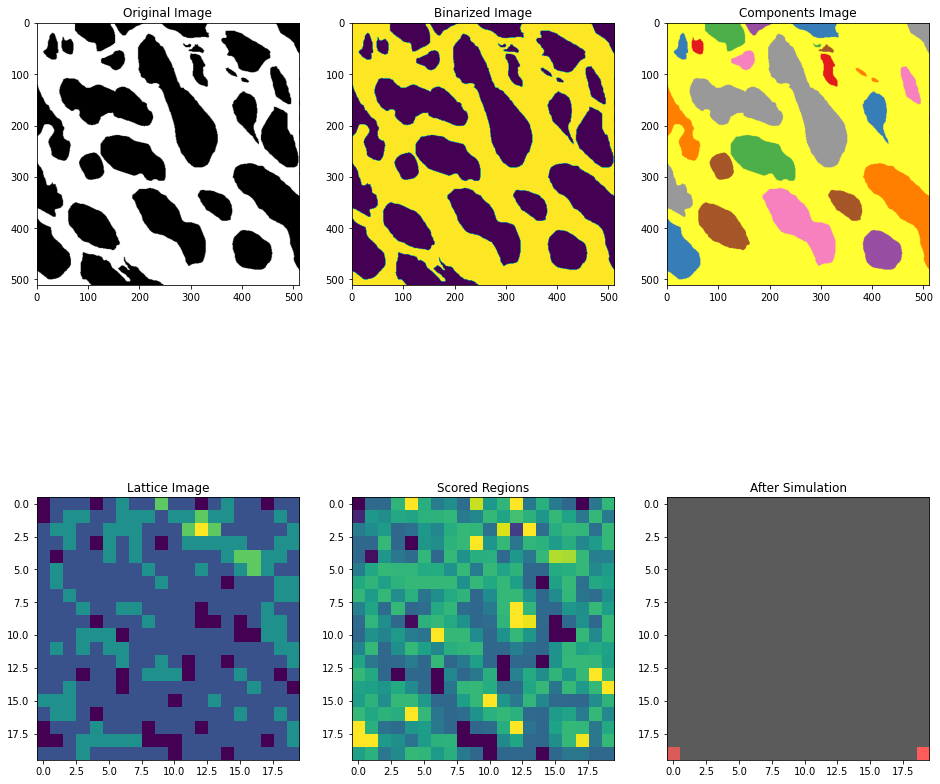

In [148]:
plot_figures(
    components,
    square_image,
    final_panes,
    binary_image,
    lattice,
    regions,
    new_dirname,
)

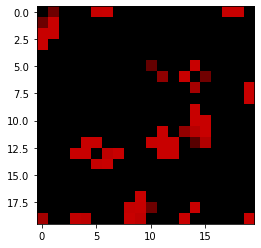

In [149]:
animation = generate_animation_image(animation_data, new_dirname);

In [150]:
HTML(animation.to_jshtml())

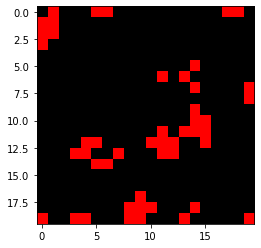

In [151]:
# Single animation
animation = generate_animation_image([animation_data[0]], new_dirname);

In [152]:
HTML(animation.to_jshtml())

In [153]:
grid, animation = animate_cells(num_free_cells, regions, max_iterations, neighborhood)

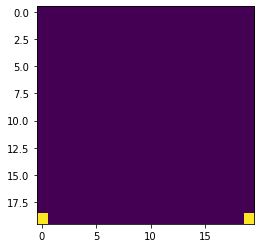

In [154]:
plt.imshow(grid);

In [ ]:
n = 5
nrange = range(1, n)
left = np.array(list(reversed(nrange)))
right = np.array(nrange)


x = 1/np.hstack([left, [1], right])**2
x[n-1] = 0

y = 1/np.hstack([left, [1], right])**2
y[n-1] = 0

np.meshgrid()

In [145]:
n = 5
grid = [[0 for _ in range(n*2+1)] for _ in range(n*2+1)]

for r, row in enumerate(grid):
    for c, col in enumerate(row):
        grid[r][c] = np.sqrt((n - r)**2 + (n - c)**2)
        
grid = np.array(grid)
grid[n,n] = 1
grid = 1/np.array(grid)
grid[n,n] = 0
grid

array([[0.141, 0.156, 0.171, 0.186, 0.196, 0.2  , 0.196, 0.186, 0.171,
        0.156, 0.141],
       [0.156, 0.177, 0.2  , 0.224, 0.243, 0.25 , 0.243, 0.224, 0.2  ,
        0.177, 0.156],
       [0.171, 0.2  , 0.236, 0.277, 0.316, 0.333, 0.316, 0.277, 0.236,
        0.2  , 0.171],
       [0.186, 0.224, 0.277, 0.354, 0.447, 0.5  , 0.447, 0.354, 0.277,
        0.224, 0.186],
       [0.196, 0.243, 0.316, 0.447, 0.707, 1.   , 0.707, 0.447, 0.316,
        0.243, 0.196],
       [0.2  , 0.25 , 0.333, 0.5  , 1.   , 0.   , 1.   , 0.5  , 0.333,
        0.25 , 0.2  ],
       [0.196, 0.243, 0.316, 0.447, 0.707, 1.   , 0.707, 0.447, 0.316,
        0.243, 0.196],
       [0.186, 0.224, 0.277, 0.354, 0.447, 0.5  , 0.447, 0.354, 0.277,
        0.224, 0.186],
       [0.171, 0.2  , 0.236, 0.277, 0.316, 0.333, 0.316, 0.277, 0.236,
        0.2  , 0.171],
       [0.156, 0.177, 0.2  , 0.224, 0.243, 0.25 , 0.243, 0.224, 0.2  ,
        0.177, 0.156],
       [0.141, 0.156, 0.171, 0.186, 0.196, 0.2  , 0.196, 0.1

In [125]:
width = 10
height = 10

xcell = 5
ycell = 9

neighborhood = 3

if xcell - neighborhood < 0:
    sx = abs(xcell - neighborhood)
else:
    sx = 0

if (xcell + neighborhood) > (width - 1):
    ex = (neighborhood*2+1) - abs(xcell + neighborhood - width + 1)
else:
    ex = (neighborhood*2+1)

if ycell - neighborhood < 0:
    sy = abs(ycell - neighborhood)
else:
    sy = 0

if (ycell + neighborhood) > (width - 1):
    ey = (neighborhood*2+1) - abs(ycell + neighborhood - width + 1)
else:
    ey = (neighborhood*2+1)

print(sx, ex)
grid[sy:ey, sx:ex]

0 7


array([[0.236, 0.277, 0.316, 0.333, 0.316, 0.277, 0.236],
       [0.277, 0.354, 0.447, 0.5  , 0.447, 0.354, 0.277],
       [0.316, 0.447, 0.707, 1.   , 0.707, 0.447, 0.316],
       [0.333, 0.5  , 1.   , 0.   , 1.   , 0.5  , 0.333]])